In [1]:
using Pkg
Pkg.activate("C:/Users/lisah/Documents/Repos/ma-code")
include("c:/Users/lisah/Documents/Repos/ma-code/src/src.jl")

  Activating project at `C:\Users\lisah\Documents\Repos\ma-code`


Main.Src

In [2]:
using Plots, JLD2

In [3]:
N = 5000
t_end = 100.0
t_fixed = true
M = 1000
path = "C:/Users/lisah/Documents/Repos/ma-code/temp_saves"

"C:/Users/lisah/Documents/Repos/ma-code/temp_saves"

### plotting tools

In [4]:
"""
    function sobol_index_subplot(sobol::Vector, comp::String; title::String="")

create plot of sobol indices for all parameters for one trajectory.
    
# Arguments:
    - `sobol::Vector`: sobol object returned by index computation
    - `comp::String`: compartment to which indices belong
    - `title::String`: optional subplot title
"""
function sobol_index_subplot(sobol::Vector, comp::String; title::String="")

    #colors = [:blue, :turquoise, :orange, :red]
    colors = [
        "#3070B3",  # a   → TUM blue brand
        "#F7811E",  # m   → TUM orange
        "#9ABCE4",  # w0  → TUM blue light-dark
        "#FAD080"   # n0  → TUM orange-2
    ]
    parameters = ["a", "m", "w0", "n0"];

    # extract indices for plotting
    fo = [sobol[i][:firstorder] for i in 1:M]
    to = [sobol[i][:totalorder] for i in 1:M]

    # very stupid way to create time axis
    hprm = Src.Hyperprm(1,1,1,1,M,0.0)
    sol = Src.sol_klausmeier(hprm, t_fixed=t_fixed, t_end=t_end)
    times = sol[!,"time"]

    si_plot = plot(legend=:topright)

    for k in 1:4
        col = colors[k]
        prm = parameters[k]
        plot!(times, getindex.(fo, k), label="$prm", lw=2, color=col, linestyle=:solid)
        plot!(times, getindex.(to, k), label="", lw=2, color=col, linestyle=:dash)
    end
    #xlabel!("Time")
    ylabel!("Sobol indices $comp")
    title!(title)
    return si_plot
end

"""
    function sobol_index_subplot_wn(sobol_n::Vector, sobol_w::Vector; title::String="")

create plot of sobol indices for both trajectories underneath each other, for comparing.
    
# Arguments:
    - `sobol_n::Vector`: output of compute_sobol_indices for n compartment
    - `sobol_w::Vector`: output of compute_sobol_indices for w compartment
    - `title::String`: optional title
"""
function sobol_index_subplot_wn(sobol_n::Vector, sobol_w::Vector; title::String="")

    # plot n compartment
    plot_n = sobol_index_subplot(sobol_n, "n", title = title)

    # plot w compartment
    plot_w = sobol_index_subplot(sobol_w, "w")

    # compare both
    return plot(plot_n, plot_w, layout=(2,1), size=(700,700))
end

sobol_index_subplot_wn

# Visualisation of Sobol indices

## a left of bifurcation point

In [5]:
@load "$path/dl/sobol_n_$(N)_$(t_end)_$M.jld2" sobol_n
@load "$path/dl/sobol_w_$(N)_$(t_end)_$M.jld2" sobol_w;

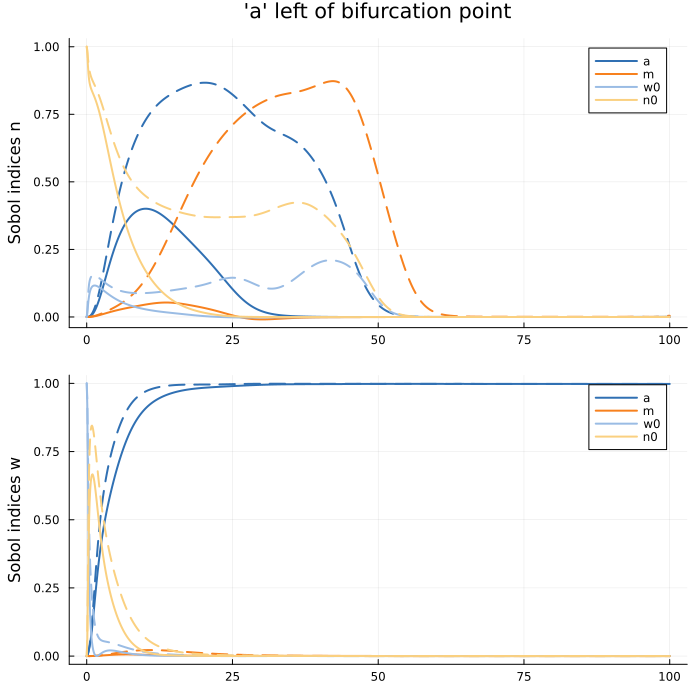

In [6]:
sobol_index_subplot_wn(sobol_n, sobol_w, title="'a' left of bifurcation point")

Interpretation:
- system always converges to stable state
- value in stable state: w=a, thus a sensitive in w compartment
- n compartment: no sensitivity once stable state is reached (then, parameter values don't matter anymore, as all lead to 0-equilibrium)
- ?: large parameter interactions present

## a around bifurcation point

In [9]:
@load "$path/dm/sobol_n_$(N)_$(t_end)_$M.jld2" sobol_n
@load "$path/dm/sobol_w_$(N)_$(t_end)_$M.jld2" sobol_w;

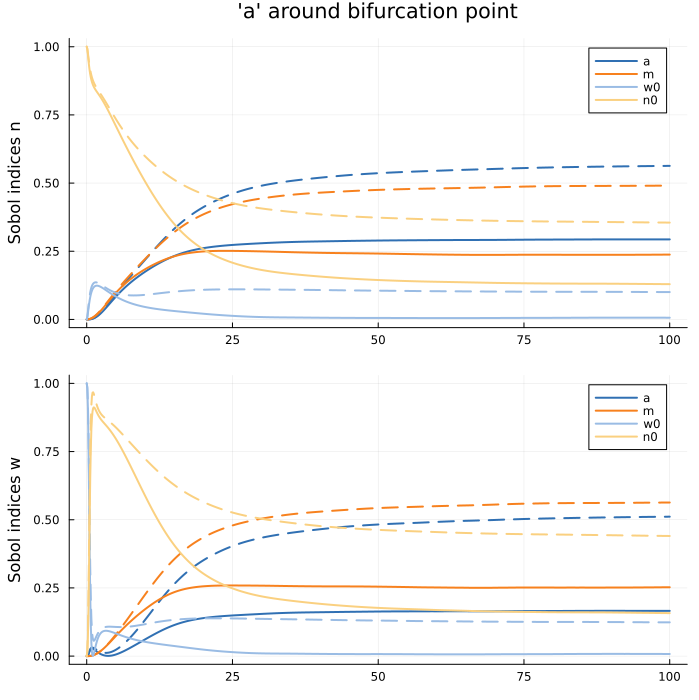

In [10]:
sobol_index_subplot_wn(sobol_n, sobol_w, title="'a' around bifurcation point")

Interpretation:
- in general high sensitivity, because we have alterante convergence to different eq.pts.
- n0 sensitive: bif.pt. at height 1, varies horizontally. Independently on a and m, n0 decides which eq.pt. system converges to
- w0 insensitive: bif. pt. varies vertically with m (only minimal), horizontally (a=2m).

what can i do?
- fix m and assess sensitivity
- fix n0

## a right of bifurcation point

### convergence to plant-free equilibrium

In [11]:
@load "$path/dr/sobol_n_$(N)_$(t_end)_$(M)_pf.jld2" sobol_n
@load "$path/dr/sobol_w_$(N)_$(t_end)_$(M)_pf.jld2" sobol_w;

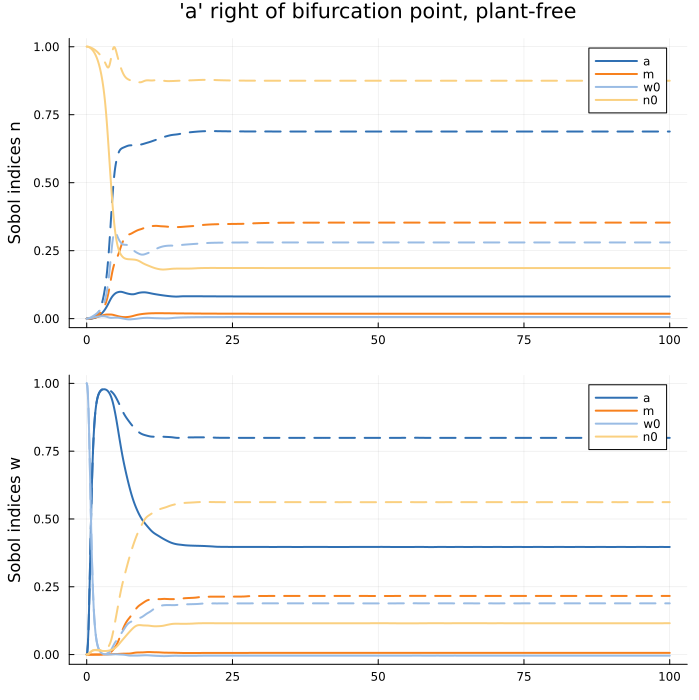

In [12]:
sobol_index_subplot_wn(sobol_n, sobol_w, title="'a' right of bifurcation point, plant-free")

Interpretation:
- n compartment: little to no sensitivity in the single parameters, high interactions though.
- ?: why is n0 more sensitive than rest. maybe because when eq.pt. shifts in a few cases also convergence to other eq.pt.?
- w compartment: always convergence to w=a, thus a sensitive

### convergence to other equilibrium

In [13]:
@load "$path/dr/sobol_n_$(N)_$(t_end)_$M.jld2" sobol_n
@load "$path/dr/sobol_w_$(N)_$(t_end)_$M.jld2" sobol_w;

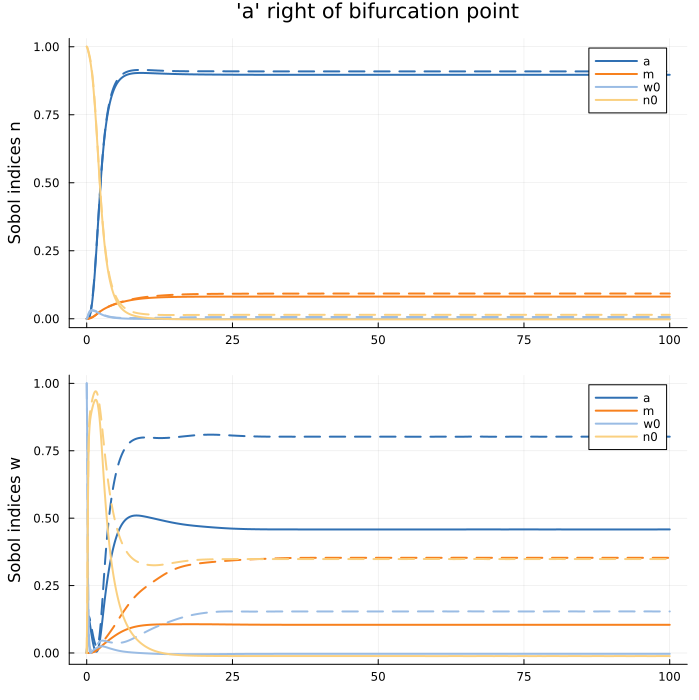

In [14]:
sobol_index_subplot_wn(sobol_n, sobol_w, title="'a' right of bifurcation point")

Interpretation:
- n compartment: a sensitive, because determines stable value of n, rest insensitive, because always convergence to same eq.pt. and location of bifurcation, which varies with m does not matter.
- w compartment: a sensitive, because determines stable value of w, rest insensitive, because always convergence to same eq.pt. and location of bifurcation, which varies with m does not matter. Interactions are present though